In [13]:
import json
import pandas as pd
import numpy as np

import re

from sqlalchemy import create_engine
import psycopg2

# from config import db_password

import time

In [14]:
# 1. Add the clean movie function that takes in the argument, "movie".
def clean_movie(movie):
        movie = dict(movie) #create a non-destructive copy
        alt_titles = {}
        #Loop through a list of all alternative title keys
        for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                    'Hangul','Hebrew','Hepburn','Japanese','Literally',
                    'Mandarin','McCune–Reischauer','Original title','Polish',
                    'Revised Romanization','Romanized','Russian',
                    'Simplified','Traditional','Yiddish']:
            # Check if the current key exists in the movie object
            if key in movie:
                # If so, remove the key-value pair and add to the alternative titles dictionary
                alt_titles[key] = movie[key]
                movie.pop(key)
        # After looping through every key, add the alternative titles dict to the movie object
        if len(alt_titles) > 0:
            movie['alt_titles'] = alt_titles
      
        def change_column_name(old_name, new_name):
            if old_name in movie:
                movie[new_name] = movie.pop(old_name)
        change_column_name('Adaptation by', 'Writer(s)')
        change_column_name('Country of origin', 'Country')
        change_column_name('Directed by', 'Director')
        change_column_name('Distributed by', 'Distributor')
        change_column_name('Edited by', 'Editor(s)')
        change_column_name('Length', 'Running time')
        change_column_name('Original release', 'Release date')
        change_column_name('Music by', 'Composer(s)')
        change_column_name('Produced by', 'Producer(s)')
        change_column_name('Producer', 'Producer(s)')
        change_column_name('Productioncompanies ', 'Production company(s)')
        change_column_name('Productioncompany ', 'Production company(s)')
        change_column_name('Released', 'Release Date')
        change_column_name('Release Date', 'Release date')
        change_column_name('Screen story by', 'Writer(s)')
        change_column_name('Screenplay by', 'Writer(s)')
        change_column_name('Story by', 'Writer(s)')
        change_column_name('Theme music composer', 'Composer(s)')
        change_column_name('Written by', 'Writer(s)')

        return movie

In [39]:
# 2 Add the function that takes in three arguments;
# Wikipedia data, Kaggle metadata, and MovieLens rating data (from Kaggle)

def extract_transform_load(load_1, load_2, load_3):
    # Read in the kaggle metadata and MovieLens ratings CSV files as Pandas DataFrames.
    kaggle_metadata = pd.read_csv(load_2, low_memory=False)
    ratings = pd.read_csv(load_3)

    # Open and read the Wikipedia data JSON file.
    for wiki_json in load_1:
        with open(load_1, mode='r') as file:
            wiki_movies_raw = json.load(file)
    
    # 3. Write a list comprehension to filter out TV shows.
        wiki_movies = [movie for movie in wiki_movies_raw
               if ('Director' in movie or 'Directed by' in movie)
                   and 'imdb_link' in movie
                   and 'No. of episodes' not in movie]

    # 4. Write a list comprehension to iterate through the cleaned wiki movies list
    # and call the clean_movie function on each movie.
    clean_movies = [clean_movie(movie) for movie in wiki_movies]

    # 5. Read in the cleaned movies list from Step 4 as a DataFrame.
    wiki_movies_df = pd.DataFrame(clean_movies)
    sorted(wiki_movies_df.columns.tolist())
    
    # 6. Write a try-except block to catch errors while extracting the IMDb ID using a regular expression string and
    #  dropping any imdb_id duplicates. If there is an error, capture and print the exception.
    
    try:
        wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
        wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
    except ValueError:
        print("Could not convert data to an integer.")
    except:
        print("Unexpected error:", sys.exc_info()[0])
    
    #  7. Write a list comprehension to keep the columns that don't have null values from the wiki_movies_df DataFrame.
    wiki_columns_to_keep = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum()
                        < len(wiki_movies_df) * 0.9]
    wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]

    # 8. Create a variable that will hold the non-null values from the “Box office” column.
    box_office = wiki_movies_df['Box office'].dropna()
    
    # 9. Convert the box office data created in Step 8 to string values using the lambda and join functions.
    box_office[box_office.map(lambda x: type(x) != str)]
    box_office = box_office.apply(lambda x: ' '.join(x) if type(x) == list else x)
    
    # 10. Write a regular expression to match the six elements of "form_one" of the box office data.
    form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'
    # 11. Write a regular expression to match the three elements of "form_two" of the box office data.
    form_two = r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)'
    
    box_office = box_office.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)
    
    # Create the two Boolean series that select the box office values that don't match either:
        #matches_form_one = box_office.str.contains(form_one, flags=re.IGNORECASE, na=False)
        #matches_form_two = box_office.str.contains(form_two, flags=re.IGNORECASE, na=False)
    # Return the data entries that do not fit the previously coded regex formatting.
        #box_office[~matches_form_one & ~matches_form_two]
        
    # Extract the part of the strings that match
    box_office.str.extract(f'({form_one}|{form_two})')

    # 12. Add the parse_dollars function.
    def parse_dollars(s):
    # if s is not a string, return NaN
        if type(s) != str:
            return np.nan

        # if input is of the form $###.# million
        if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):

            # remove dollar sign and " million"
            s = re.sub('\$|\s|[a-zA-Z]','', s)

            # convert to float and multiply by a million
            value = float(s) * 10**6

            # return value
            return value

        # if input is of the form $###.# billion
        elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):

            # remove dollar sign and " billion"
            s = re.sub('\$|\s|[a-zA-Z]','', s)

            # convert to float and multiply by a billion
            value = float(s) * 10**9

            # return value
            return value

        # if input is of the form $###,###,###
        elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):

            # remove dollar sign and commas
            s = re.sub('\$|,','', s)

            # convert to float
            value = float(s)

            # return value
            return value

        # otherwise, return NaN
        else:
            return np.nan
    
        
    # 13. Clean the box office column in the wiki_movies_df DataFrame.
    # Parse the box office values to numeric values.
    # First extract the values from box_office using str.extract.
    # Apply parse_dollars to the first column in the DataFrame returned by str.extract.
    wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})',
                                                          flags=re.IGNORECASE)[0].apply(parse_dollars)
    wiki_movies_df.drop('Box office', axis=1, inplace=True)
    
    # 14. Clean the budget column in the wiki_movies_df DataFrame.
    # Parse the "Budget" data.
    # Create a Budget Variable and drop empty columns
    budget = wiki_movies_df['Budget'].dropna()
    # Convert lists to strings
    budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)
    # Remove any values between a dollar sign and a hyphen (for budgets given in ranges):
    budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)
    # Use the same pattern matches for "Box Office" to parse non-matching formatting
    matches_form_one = budget.str.contains(form_one, flags=re.IGNORECASE, na=False)
    matches_form_two = budget.str.contains(form_two, flags=re.IGNORECASE, na=False)
    # Return the data entries that do not fit the previously coded regex formatting.    
        #budget[~matches_form_one & ~matches_form_two]
        
    # Remove the citation references.
    budget = budget.str.replace(r'\[\d+\]\s*', '')
    budget[~matches_form_one & ~matches_form_two]
    
    # Parse the "budget" values by reusing code from "box office" parse_dollars.
    wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})',
                                                  flags=re.IGNORECASE)[0].apply(parse_dollars)
    # Drop the original "Budget" column as it is no longer needed.
    wiki_movies_df.drop('Budget', axis=1, inplace=True)
    
    # 15. Clean the release date column in the wiki_movies_df DataFrame.
    # Create a variable that holds the non-null values of Release date in the DataFrame, converting lists to strings
    release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)
    # Create the parse code for the forms
    date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]?\d,\s\d{4}'
    date_form_two = r'\d{4}.[01]\d.[0123]\d'
    date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
    date_form_four = r'\d{4}'
    # Extract the dates.
    release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})', flags=re.IGNORECASE)
    # Parse dates using "to_datetime()" method and the "infer_datetime_format" option set to "True" since the dates are in
    #      different formats.
    wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0],
                                                                                        infer_datetime_format=True)
    
    # 16. Clean the running time column in the wiki_movies_df DataFrame.
    # Create a variable that holds the non-null values of Release date in the DataFrame, converting lists to strings.
    running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)
    # Using 'string boundaries' check to see how many movies have around 100 minutes running time.
    running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE, na=False).sum()
    # Generalize previous 'string boundary' code return by only marking the beginning of the string,
    #      and accepting other abbreviations of "minutes" by only searching up to the letter "m".
    running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE, na=False).sum()
    # Check the remaining movies running time.
    running_time[running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE, na=False) != True]
    # Extract only digits. Allow for both possible patterns.
    # Add capture groups around the \d instances as well as add an alternating character.
    running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')
    # Convert "running_time_extract" into numeric values. Because empty strings may have been captured,
    #      use the to_numeric() method and set the errors argument to 'coerce'.
    # Coercing the errors will turn the empty strings into Not a Number (NaN),
    #      then use fillna() to change all the NaNs to zeros.
    running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)
    # Apply a function that will convert the hour capture groups and minute capture groups to minutes
    #      if the pure minutes capture group is zero, and save the output to wiki_movies_df:
    wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] 
                                                                if row[2] == 0 else row[2], axis=1)
    # Drop Running time from the dataset.
    wiki_movies_df.drop('Running time', axis=1, inplace=True)
    
    # Return three variables. The first is the wiki_movies_df DataFrame
    return wiki_movies_df, kaggle_metadata, ratings

In [40]:
# 17. Create the path to your file directory and variables for the three files.
file_dir = "C://Users/avery/Vandy_Git/GitHub/Module8"
# The Wikipedia data
wiki_file = f'{file_dir}/wikipedia-movies.json'
# The Kaggle metadata
kaggle_file = f'{file_dir}/movies_metadata.csv'
# The MovieLens rating data.
ratings_file = f'{file_dir}/ratings.csv'

In [41]:
# 18. Set the three variables equal to the function created in D1.
wiki_file, kaggle_file, ratings_file = extract_transform_load(wiki_file, kaggle_file, ratings_file)

<ipython-input-39-22563e9d3ad9>:137: FutureWarning: The default value of regex will change from True to False in a future version.
  budget = budget.str.replace(r'\[\d+\]\s*', '')


In [42]:
# 19. Set the wiki_movies_df equal to the wiki_file variable. 
wiki_movies_df = pd.DataFrame(wiki_file)

In [43]:
# 20. Check that the wiki_movies_df DataFrame looks like this. 
wiki_movies_df.head()

,url,year,imdb_link,title,Based on,Starring,Cinematography,Release date,Country,Language,...,Editor(s),Composer(s),Producer(s),Production company(s),Writer(s),imdb_id,box_office,budget,release_date,running_time
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,"[July 11, 1990, (, 1990-07-11, )]",United States,English,...,Michael Tronick,"[Cliff Eidelman, Yello]","[Steve Perry, Joel Silver]",Silver Pictures,"[David Arnott, James Cappe]",tt0098987,21400000.0,20000000.0,1990-07-11,102.0
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,"[May 17, 1990, (, 1990-05-17, ), (Cannes Film ...",United States,English,...,Howard E. Smith,Maurice Jarre,"[Ric Kidney, Robert Redlin]",Avenue Pictures,"[James Foley, Robert Redlin]",tt0098994,2700000.0,6000000.0,1990-05-17,114.0
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,Air America,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,"[August 10, 1990, (, 1990-08-10, )]",United States,"[English, Lao]",...,"[John Bloom, Lois Freeman-Fox]",Charles Gross,Daniel Melnick,"[Carolco Pictures, IndieProd Company]","[John Eskow, Richard Rush]",tt0099005,57718089.0,35000000.0,1990-08-10,113.0
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,Alice,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,"[December 25, 1990, (, 1990-12-25, )]",United States,English,...,Susan E. Morse,NaN,Robert Greenhut,NaN,Woody Allen,tt0099012,7331647.0,12000000.0,1990-12-25,106.0
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,Almost an Angel,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,"December 19, 1990",US,English,...,David Stiven,Maurice Jarre,John Cornell,NaN,Paul Hogan,tt0099018,6939946.0,25000000.0,1990-12-19,95.0


In [44]:
# 21. Check that wiki_movies_df DataFrame columns are correct. 
wiki_movies_df.columns.to_list()

['url',
 'year',
 'imdb_link',
 'title',
 'Based on',
 'Starring',
 'Cinematography',
 'Release date',
 'Country',
 'Language',
 'Director',
 'Distributor',
 'Editor(s)',
 'Composer(s)',
 'Producer(s)',
 'Production company(s)',
 'Writer(s)',
 'imdb_id',
 'box_office',
 'budget',
 'release_date',
 'running_time']

#####NOTE  
The original directions say to drop the original "Budget" column as it is no longer needed; however, the wiki_movies_df.columns.to_list() clearly has it in. It is an invalid column that holds no data; so I am dropping it.

See Attached with "Budget" column still in code.
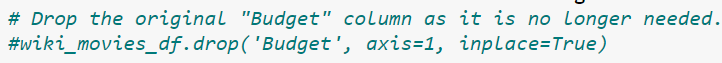



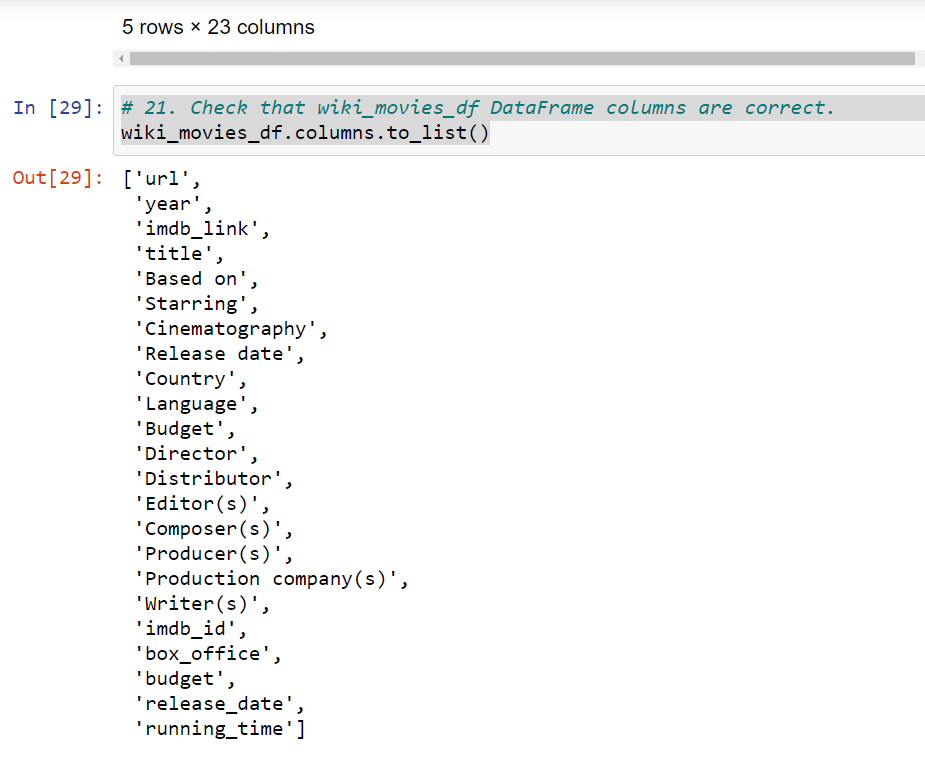